# IEEE-CIS Fraud Detection - Exploratory Data Analysis

## Overview
This notebook performs comprehensive exploratory data analysis on the IEEE-CIS Fraud Detection dataset.
The goal is to understand the data structure, identify patterns, and inform feature engineering decisions.

## Dataset Description
- **Transaction Data**: Contains transaction details including amount, card info, addresses, etc.
- **Identity Data**: Contains identity information linked to transactions via TransactionID
- **Target Variable**: `isFraud` - binary indicator of fraudulent transactions

## Key Questions to Answer
1. What is the class distribution (expected severe imbalance)?
2. What are the missing value patterns?
3. What temporal patterns exist in fraud?
4. Which features show strongest correlation with fraud?
5. What feature engineering opportunities exist?

In [1]:
# Standard library imports
import os
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define paths - using relative paths from notebooks directory
BASE_PATH = Path('..').resolve()
DATA_PATH = BASE_PATH / 'Data' / 'raw'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'visuals'

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print(f"Data Path: {DATA_PATH}")
print(f"Output Path: {OUTPUT_PATH}")

Data Path: C:\Users\Lenovo\Desktop\fraud-detection-mlops\Data\raw
Output Path: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals


## 1. Data Loading and Initial Inspection

We load both transaction and identity datasets separately first to understand their individual structures,
then merge them for comprehensive analysis. The merge is done on `TransactionID` using a left join
because not all transactions have associated identity information.

In [2]:
# Load transaction data
# Note: This is a large dataset, so we monitor memory usage
print("Loading transaction data...")
train_transaction = pd.read_csv(DATA_PATH / 'train_transaction.csv')
print(f"Transaction shape: {train_transaction.shape}")
print(f"Memory usage: {train_transaction.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nLoading identity data...")
train_identity = pd.read_csv(DATA_PATH / 'train_identity.csv')
print(f"Identity shape: {train_identity.shape}")
print(f"Memory usage: {train_identity.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading transaction data...


Transaction shape: (590540, 394)


Memory usage: 2062.07 MB

Loading identity data...


Identity shape: (144233, 41)


Memory usage: 143.14 MB


In [3]:
# Merge transaction and identity data
# Using left join because not all transactions have identity information
# This is important: missing identity data itself might be a signal for fraud
print("Merging datasets...")
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"Merged dataset shape: {train_df.shape}")
print(f"Transactions with identity info: {train_identity.shape[0]:,} ({train_identity.shape[0]/train_transaction.shape[0]*100:.1f}%)")
print(f"Transactions without identity info: {train_transaction.shape[0] - train_identity.shape[0]:,}")

# Free memory by deleting original dataframes
del train_transaction, train_identity

Merging datasets...


Merged dataset shape: (590540, 434)
Transactions with identity info: 144,233 (24.4%)
Transactions without identity info: 446,307


In [4]:
# Initial data inspection
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal Rows: {train_df.shape[0]:,}")
print(f"Total Columns: {train_df.shape[1]}")
print(f"\nColumn Data Types:")
print(train_df.dtypes.value_counts())

DATASET OVERVIEW

Total Rows: 590,540
Total Columns: 434

Column Data Types:
float64    399
object      31
int64        4
Name: count, dtype: int64


In [5]:
# Display first few rows of key columns
key_columns = ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 
               'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']
train_df[key_columns].head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,P_emaildomain,R_emaildomain
0,2987000,0,86400,68.5,W,13926,discover,credit,NaN,NaN
1,2987001,0,86401,29.0,W,2755,mastercard,credit,gmail.com,NaN
2,2987002,0,86469,59.0,W,4663,visa,debit,outlook.com,NaN
3,2987003,0,86499,50.0,W,18132,mastercard,debit,yahoo.com,NaN
4,2987004,0,86506,50.0,H,4497,mastercard,credit,gmail.com,NaN
5,2987005,0,86510,49.0,W,5937,visa,debit,gmail.com,NaN
6,2987006,0,86522,159.0,W,12308,visa,debit,yahoo.com,NaN
7,2987007,0,86529,422.5,W,12695,visa,debit,mail.com,NaN
8,2987008,0,86535,15.0,H,2803,visa,debit,anonymous.com,NaN
9,2987009,0,86536,117.0,W,17399,mastercard,debit,yahoo.com,NaN


## 2. Target Variable Analysis

Understanding the class distribution is critical for fraud detection.
We expect severe class imbalance (typically 1-5% fraud rate) which has significant implications:
- Standard accuracy metrics will be misleading
- We need specialized techniques (SMOTE, class weights, undersampling)
- Evaluation should focus on precision-recall rather than accuracy

In [6]:
# Target variable distribution
fraud_counts = train_df['isFraud'].value_counts()
fraud_pct = train_df['isFraud'].value_counts(normalize=True) * 100

print("=" * 60)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(f"\nLegitimate Transactions (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraudulent Transactions (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: 1:{fraud_counts[0]//fraud_counts[1]}")
print("\nIMPLICATIONS:")
print("- Severe class imbalance requires specialized handling")
print("- Accuracy metric would be misleading (>96% by predicting all 0s)")
print("- Will use precision-recall AUC as primary metric")
print("- Consider SMOTE or class weights during modeling")

TARGET VARIABLE DISTRIBUTION

Legitimate Transactions (0): 569,877 (96.50%)
Fraudulent Transactions (1): 20,663 (3.50%)

Class Imbalance Ratio: 1:27

IMPLICATIONS:
- Severe class imbalance requires specialized handling
- Accuracy metric would be misleading (>96% by predicting all 0s)
- Will use precision-recall AUC as primary metric
- Consider SMOTE or class weights during modeling


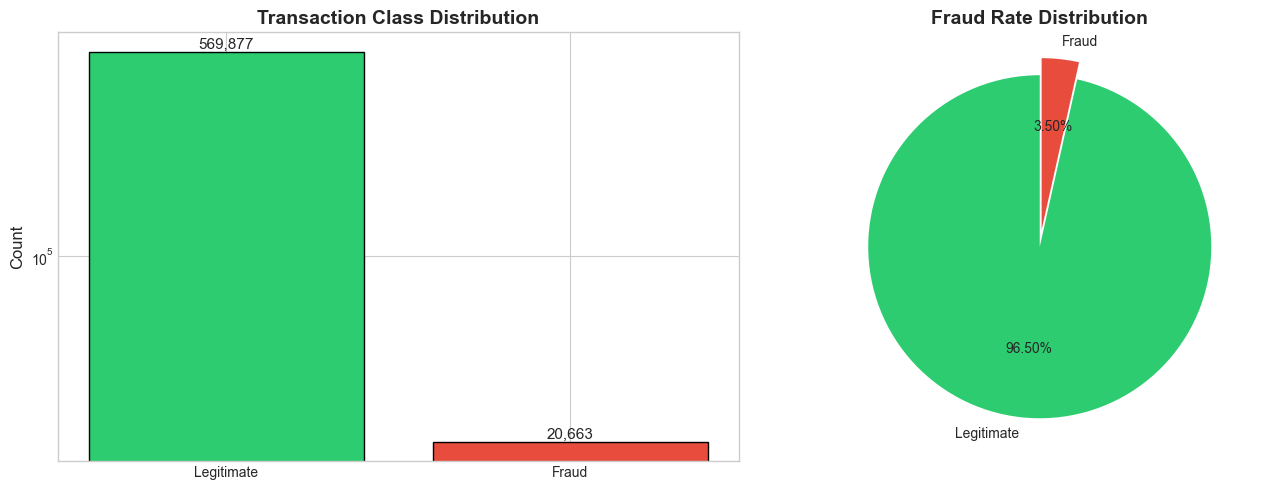

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\01_target_distribution.png


In [7]:
# Visualization 1: Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Transaction Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')  # Log scale due to imbalance
for bar, count in zip(bars, fraud_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{count:,}', ha='center', va='bottom', fontsize=11)

# Pie chart
axes[1].pie(fraud_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%',
            colors=colors, explode=[0, 0.1], startangle=90)
axes[1].set_title('Fraud Rate Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '01_target_distribution.png'}")

## 3. Missing Value Analysis

Missing values are common in fraud detection datasets and can carry information.
Key considerations:
- High missing rates in identity features (expected - not all transactions have identity info)
- V-columns (Vesta engineered features) have structured missing patterns
- Missing data patterns themselves can be predictive of fraud

In [8]:
# Calculate missing values
missing_df = pd.DataFrame({
    'column': train_df.columns,
    'missing_count': train_df.isnull().sum().values,
    'missing_pct': (train_df.isnull().sum() / len(train_df) * 100).values
}).sort_values('missing_pct', ascending=False)

print("=" * 60)
print("MISSING VALUE SUMMARY")
print("=" * 60)
print(f"\nColumns with no missing values: {(missing_df['missing_pct'] == 0).sum()}")
print(f"Columns with <10% missing: {((missing_df['missing_pct'] > 0) & (missing_df['missing_pct'] < 10)).sum()}")
print(f"Columns with 10-50% missing: {((missing_df['missing_pct'] >= 10) & (missing_df['missing_pct'] < 50)).sum()}")
print(f"Columns with 50-90% missing: {((missing_df['missing_pct'] >= 50) & (missing_df['missing_pct'] < 90)).sum()}")
print(f"Columns with >90% missing: {(missing_df['missing_pct'] >= 90).sum()}")

MISSING VALUE SUMMARY

Columns with no missing values: 20
Columns with <10% missing: 92
Columns with 10-50% missing: 108
Columns with 50-90% missing: 202
Columns with >90% missing: 12


In [9]:
# Top 30 columns with highest missing values
print("\nTop 30 Columns with Highest Missing Values:")
print(missing_df.head(30).to_string(index=False))


Top 30 Columns with Highest Missing Values:
column  missing_count  missing_pct
 id_24         585793    99.196159
 id_25         585408    99.130965
 id_07         585385    99.127070
 id_08         585385    99.127070
 id_21         585381    99.126393
 id_26         585377    99.125715
 id_22         585371    99.124699
 id_27         585371    99.124699
 id_23         585371    99.124699
 dist2         552913    93.628374
    D7         551623    93.409930
 id_18         545427    92.360721
   D13         528588    89.509263
   D14         528353    89.469469
   D12         525823    89.041047
 id_04         524216    88.768923
 id_03         524216    88.768923
    D6         517353    87.606767
 id_33         517251    87.589494
    D8         515614    87.312290
    D9         515614    87.312290
 id_09         515614    87.312290
 id_10         515614    87.312290
 id_30         512975    86.865411
 id_32         512954    86.861855
 id_34         512735    86.824771
 id_14    

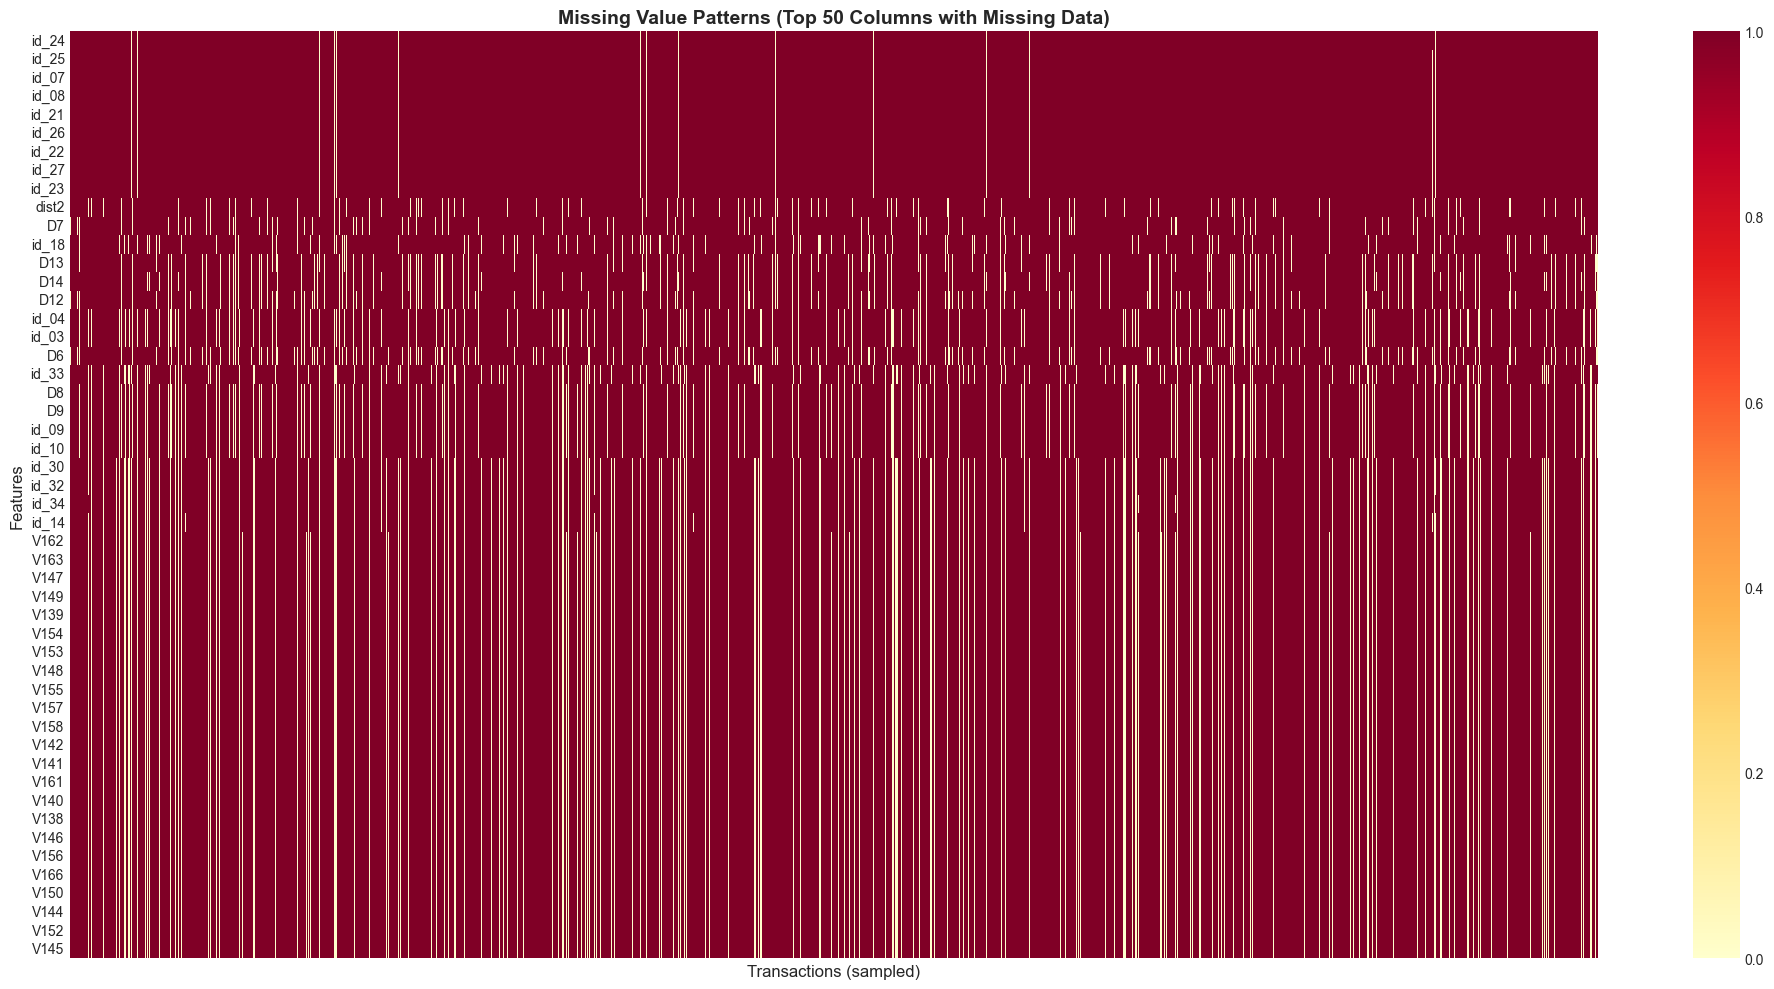

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\02_missing_value_heatmap.png


In [10]:
# Visualization 2: Missing Value Heatmap
# Select columns with significant missing values for visualization
cols_with_missing = missing_df[missing_df['missing_pct'] > 0]['column'].tolist()[:50]

fig, ax = plt.subplots(figsize=(20, 10))

# Sample data for visualization (full dataset too large for heatmap)
sample_idx = np.random.choice(train_df.index, size=min(5000, len(train_df)), replace=False)
missing_matrix = train_df.loc[sample_idx, cols_with_missing].isnull().astype(int)

sns.heatmap(missing_matrix.T, cbar=True, cmap='YlOrRd', 
            yticklabels=True, xticklabels=False)
ax.set_title('Missing Value Patterns (Top 50 Columns with Missing Data)', fontsize=14, fontweight='bold')
ax.set_xlabel('Transactions (sampled)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '02_missing_value_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '02_missing_value_heatmap.png'}")

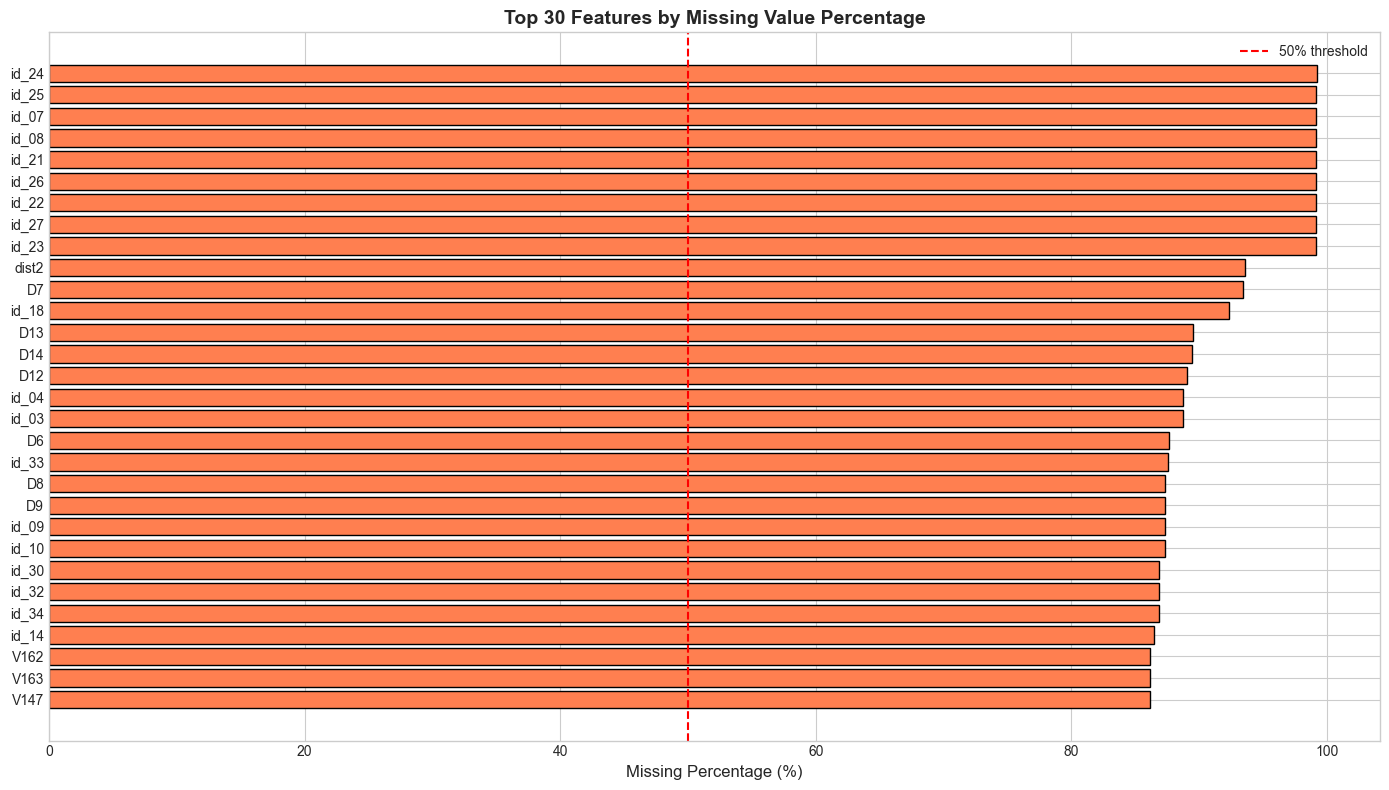

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\03_missing_values_bar.png


In [11]:
# Visualization 3: Missing Values Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))

# Top 30 columns with missing values
top_missing = missing_df[missing_df['missing_pct'] > 0].head(30)

bars = ax.barh(top_missing['column'], top_missing['missing_pct'], color='coral', edgecolor='black')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_title('Top 30 Features by Missing Value Percentage', fontsize=14, fontweight='bold')
ax.axvline(x=50, color='red', linestyle='--', label='50% threshold')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '03_missing_values_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '03_missing_values_bar.png'}")

## 4. Feature Type Identification

Categorizing features is essential for appropriate preprocessing:
- **Numerical**: Continuous values (amounts, counts, V-features)
- **Categorical**: Discrete categories (card types, product codes, device info)
- **Temporal**: Time-related (TransactionDT)
- **ID-like**: High cardinality identifiers (card1, addr1)

In [12]:
# Identify feature types
def categorize_features(df):
    """Categorize features into numerical, categorical, and temporal types."""
    
    numerical_cols = []
    categorical_cols = []
    id_cols = ['TransactionID']  # Explicitly mark ID columns
    target_col = ['isFraud']
    temporal_cols = ['TransactionDT']
    
    for col in df.columns:
        if col in id_cols + target_col + temporal_cols:
            continue
            
        # Check if column is object type (usually categorical)
        if df[col].dtype == 'object':
            categorical_cols.append(col)
        # Check if numerical with few unique values (likely categorical)
        elif df[col].nunique() < 20 and df[col].dtype in ['int64', 'float64']:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
    
    return {
        'numerical': numerical_cols,
        'categorical': categorical_cols,
        'temporal': temporal_cols,
        'id': id_cols,
        'target': target_col
    }

feature_types = categorize_features(train_df)

print("=" * 60)
print("FEATURE TYPE SUMMARY")
print("=" * 60)
print(f"\nNumerical features: {len(feature_types['numerical'])}")
print(f"Categorical features: {len(feature_types['categorical'])}")
print(f"Temporal features: {len(feature_types['temporal'])}")
print(f"ID features: {len(feature_types['id'])}")

FEATURE TYPE SUMMARY

Numerical features: 261
Categorical features: 170
Temporal features: 1
ID features: 1


In [13]:
# Detailed feature groups based on naming conventions
feature_groups = {
    'Card Features': [c for c in train_df.columns if c.startswith('card')],
    'Address Features': [c for c in train_df.columns if c.startswith('addr')],
    'Email Features': [c for c in train_df.columns if 'email' in c.lower()],
    'C Features (Counting)': [c for c in train_df.columns if c.startswith('C') and c[1:].isdigit()],
    'D Features (Timedelta)': [c for c in train_df.columns if c.startswith('D') and c[1:].isdigit()],
    'M Features (Match)': [c for c in train_df.columns if c.startswith('M') and c[1:].isdigit()],
    'V Features (Vesta)': [c for c in train_df.columns if c.startswith('V')],
    'Identity Features': [c for c in train_df.columns if c.startswith('id_')],
    'Device Features': [c for c in train_df.columns if 'Device' in c]
}

print("\nFeature Groups:")
for group, cols in feature_groups.items():
    print(f"  {group}: {len(cols)} features")


Feature Groups:
  Card Features: 6 features
  Address Features: 2 features
  Email Features: 2 features
  C Features (Counting): 14 features
  D Features (Timedelta): 15 features
  M Features (Match): 9 features
  V Features (Vesta): 339 features
  Identity Features: 38 features
  Device Features: 2 features


In [14]:
# Categorical features - cardinality analysis
print("\nCategorical Feature Cardinality (Top 20):")
cardinality = {col: train_df[col].nunique() for col in feature_types['categorical']}
cardinality_sorted = sorted(cardinality.items(), key=lambda x: x[1], reverse=True)[:20]
for col, nunique in cardinality_sorted:
    print(f"  {col}: {nunique:,} unique values")


Categorical Feature Cardinality (Top 20):


  DeviceInfo: 1,786 unique values
  id_33: 260 unique values
  id_31: 130 unique values
  id_30: 75 unique values
  R_emaildomain: 60 unique values
  P_emaildomain: 59 unique values
  V153: 19 unique values
  V154: 19 unique values
  V247: 19 unique values
  V250: 19 unique values
  V251: 19 unique values
  V327: 19 unique values
  V40: 18 unique values
  V55: 18 unique values
  id_18: 18 unique values
  V59: 17 unique values
  V60: 17 unique values
  V184: 17 unique values
  V195: 17 unique values
  V223: 17 unique values


## 5. Transaction Amount Analysis

Transaction amount is often a key indicator for fraud detection.
We analyze:
- Distribution of amounts for fraud vs legitimate
- Statistical differences between classes
- Outlier patterns

In [15]:
# Transaction Amount Statistics by Fraud Status
print("=" * 60)
print("TRANSACTION AMOUNT ANALYSIS")
print("=" * 60)

amount_stats = train_df.groupby('isFraud')['TransactionAmt'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
amount_stats.index = ['Legitimate', 'Fraud']
print("\nTransaction Amount Statistics:")
print(amount_stats.round(2))

TRANSACTION AMOUNT ANALYSIS

Transaction Amount Statistics:
             count    mean  median     std   min       max
Legitimate  569877  134.51    68.5  239.40  0.25  31937.39
Fraud        20663  149.24    75.0  232.21  0.29   5191.00


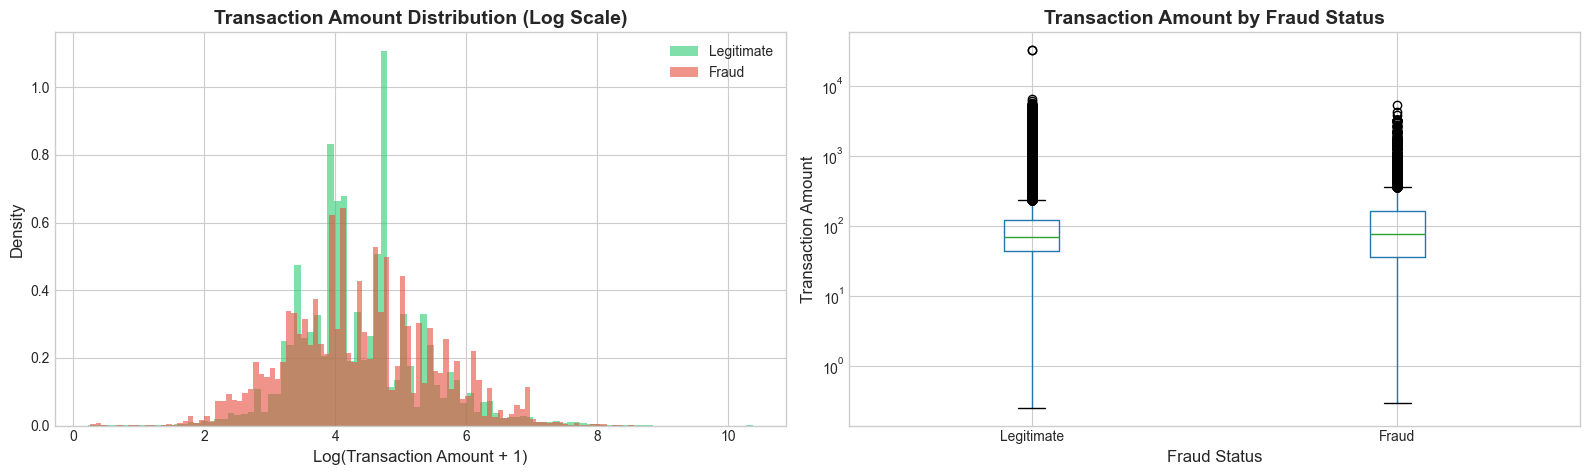

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\04_transaction_amount_distribution.png


In [16]:
# Visualization 4: Transaction Amount Distribution by Fraud Status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Log-transformed distribution
for fraud_val, color, label in [(0, '#2ecc71', 'Legitimate'), (1, '#e74c3c', 'Fraud')]:
    subset = train_df[train_df['isFraud'] == fraud_val]['TransactionAmt']
    axes[0].hist(np.log1p(subset), bins=100, alpha=0.6, color=color, label=label, density=True)

axes[0].set_xlabel('Log(Transaction Amount + 1)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Transaction Amount Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[0].legend()

# Box plot
train_df.boxplot(column='TransactionAmt', by='isFraud', ax=axes[1])
axes[1].set_xlabel('Fraud Status', fontsize=12)
axes[1].set_ylabel('Transaction Amount', fontsize=12)
axes[1].set_title('Transaction Amount by Fraud Status', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['Legitimate', 'Fraud'])
axes[1].set_yscale('log')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '04_transaction_amount_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '04_transaction_amount_distribution.png'}")

## 6. Temporal Pattern Analysis

TransactionDT represents seconds from a reference time. Fraud often shows temporal patterns:
- Time of day effects (late night transactions)
- Day of week patterns
- Burst patterns (multiple rapid transactions)

**Note**: We use time-based train/test split for modeling to simulate production deployment.

In [17]:
# Create temporal features for analysis
# TransactionDT is in seconds, we convert to days and extract patterns
train_df['TransactionDay'] = train_df['TransactionDT'] // (24 * 60 * 60)
train_df['TransactionHour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['TransactionDayOfWeek'] = (train_df['TransactionDT'] // (24 * 60 * 60)) % 7

print("=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)
print(f"\nTransaction time span: {train_df['TransactionDay'].min()} to {train_df['TransactionDay'].max()} days")
print(f"Total days of data: {train_df['TransactionDay'].nunique()} days")

TEMPORAL ANALYSIS

Transaction time span: 1 to 182 days
Total days of data: 182 days


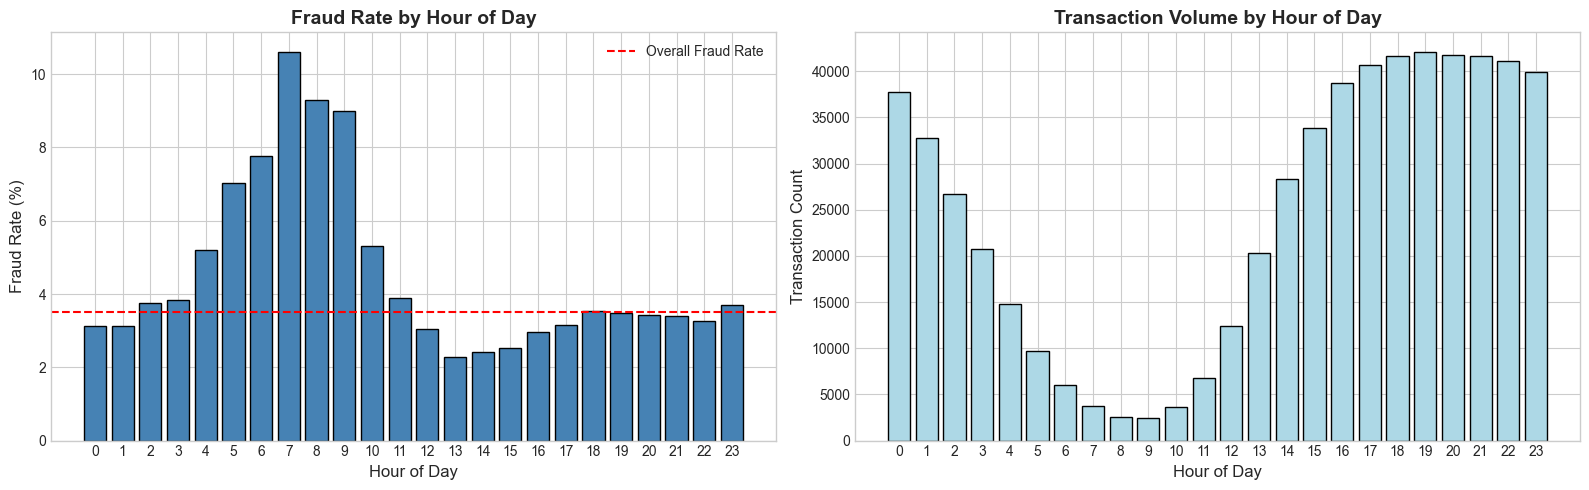

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\05_hourly_patterns.png


In [18]:
# Visualization 5: Fraud Rate by Hour of Day
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Hourly fraud rate
hourly_fraud = train_df.groupby('TransactionHour')['isFraud'].mean() * 100
axes[0].bar(hourly_fraud.index, hourly_fraud.values, color='steelblue', edgecolor='black')
axes[0].axhline(y=train_df['isFraud'].mean() * 100, color='red', linestyle='--', label='Overall Fraud Rate')
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[0].set_title('Fraud Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xticks(range(24))

# Transaction volume by hour
hourly_volume = train_df.groupby('TransactionHour').size()
axes[1].bar(hourly_volume.index, hourly_volume.values, color='lightblue', edgecolor='black')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Transaction Count', fontsize=12)
axes[1].set_title('Transaction Volume by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '05_hourly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '05_hourly_patterns.png'}")

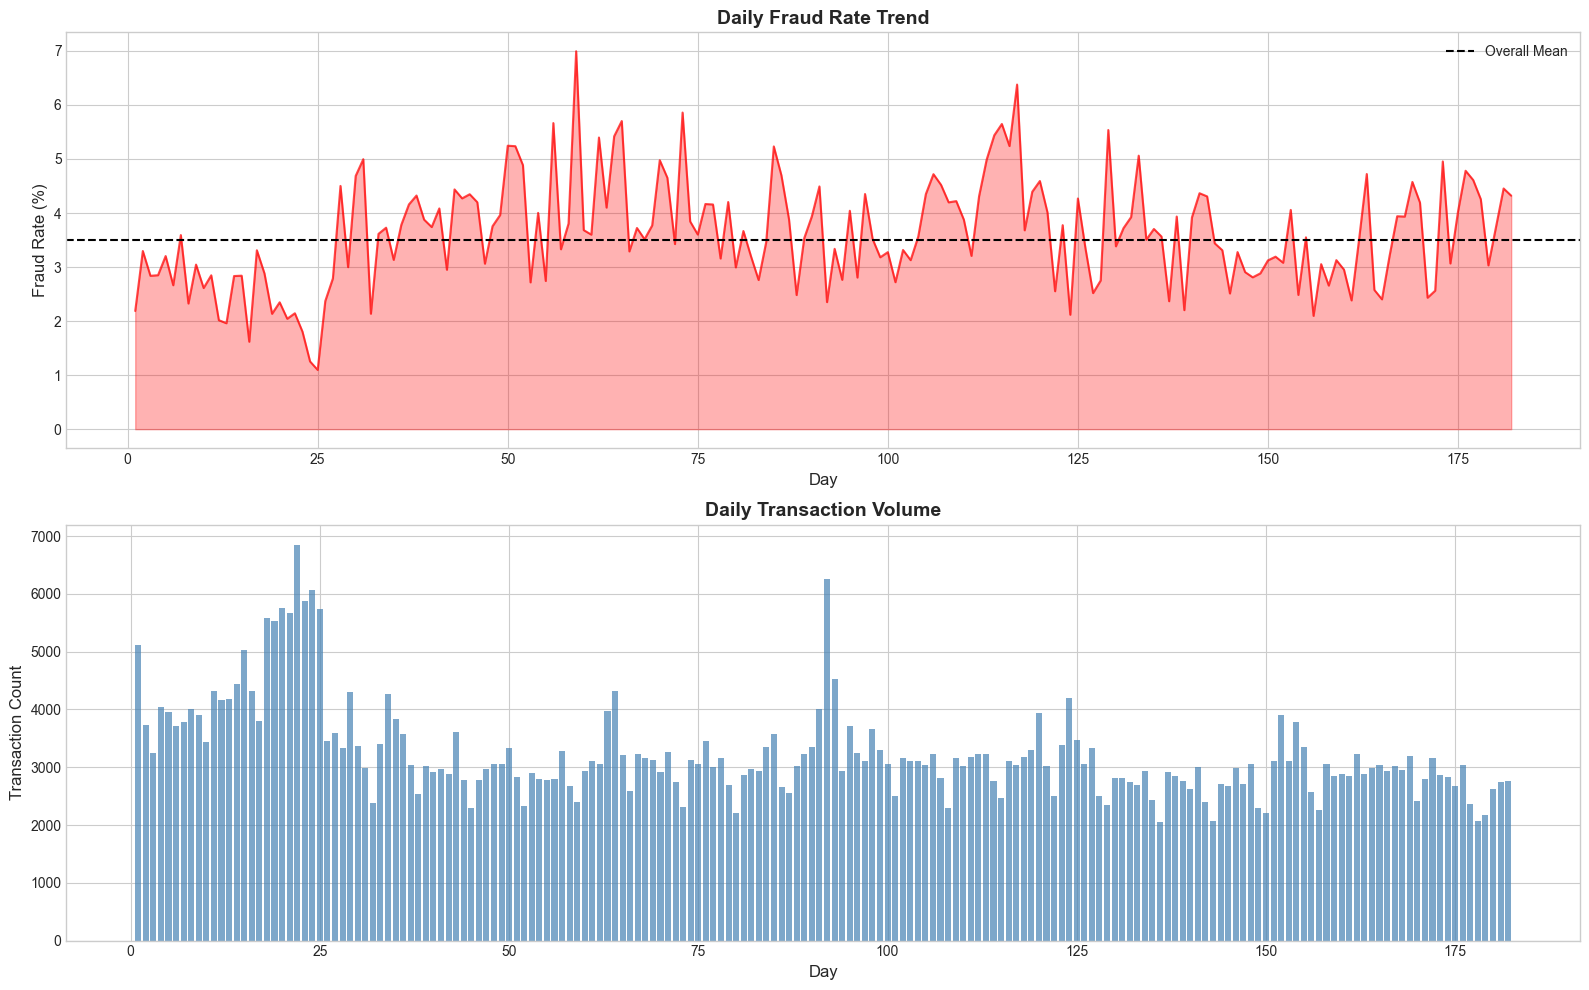

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\06_daily_trends.png

OBSERVATIONS:
- Fraud rate varies over time, suggesting concept drift considerations
- This justifies using time-based split for training/validation


In [19]:
# Visualization 6: Fraud Rate Over Time (Daily)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily fraud rate trend
daily_stats = train_df.groupby('TransactionDay').agg({
    'isFraud': ['sum', 'count', 'mean']
}).reset_index()
daily_stats.columns = ['Day', 'FraudCount', 'TotalCount', 'FraudRate']

axes[0].plot(daily_stats['Day'], daily_stats['FraudRate'] * 100, color='red', alpha=0.7)
axes[0].fill_between(daily_stats['Day'], daily_stats['FraudRate'] * 100, alpha=0.3, color='red')
axes[0].axhline(y=train_df['isFraud'].mean() * 100, color='black', linestyle='--', label='Overall Mean')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[0].set_title('Daily Fraud Rate Trend', fontsize=14, fontweight='bold')
axes[0].legend()

# Transaction volume over time
axes[1].bar(daily_stats['Day'], daily_stats['TotalCount'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Transaction Count', fontsize=12)
axes[1].set_title('Daily Transaction Volume', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '06_daily_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '06_daily_trends.png'}")

print("\nOBSERVATIONS:")
print("- Fraud rate varies over time, suggesting concept drift considerations")
print("- This justifies using time-based split for training/validation")

## 7. Categorical Feature Analysis

Analyzing key categorical features to understand fraud patterns:
- ProductCD: Product type
- Card types (card4, card6)
- Email domains

In [20]:
# ProductCD Analysis
print("=" * 60)
print("PRODUCT CODE ANALYSIS")
print("=" * 60)

product_analysis = train_df.groupby('ProductCD').agg({
    'isFraud': ['sum', 'count', 'mean']
}).round(4)
product_analysis.columns = ['FraudCount', 'TotalCount', 'FraudRate']
product_analysis['FraudRate'] = product_analysis['FraudRate'] * 100
product_analysis = product_analysis.sort_values('FraudRate', ascending=False)
print(product_analysis)

PRODUCT CODE ANALYSIS
           FraudCount  TotalCount  FraudRate
ProductCD                                   
C                8008       68519      11.69
S                 686       11628       5.90
H                1574       33024       4.77
R                1426       37699       3.78
W                8969      439670       2.04


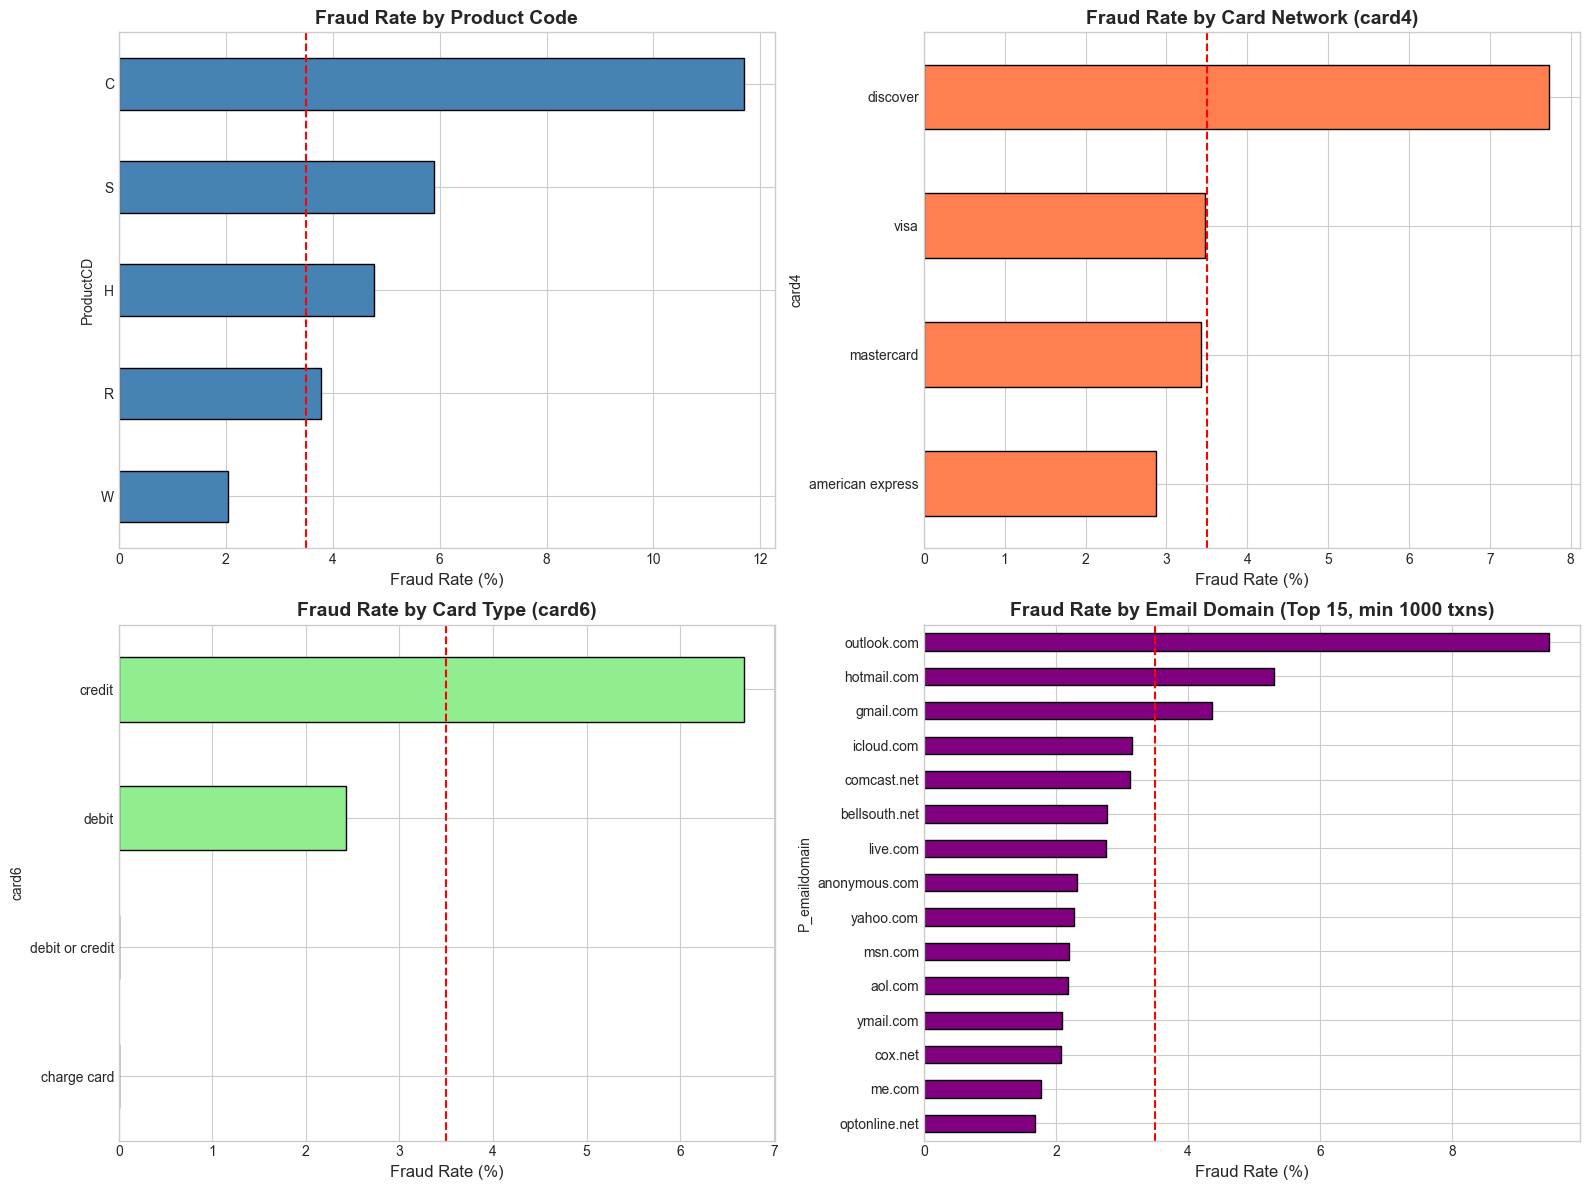

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\07_categorical_fraud_rates.png


In [21]:
# Visualization 7: Fraud Rate by Key Categorical Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ProductCD
product_fraud = train_df.groupby('ProductCD')['isFraud'].mean() * 100
product_fraud.sort_values(ascending=True).plot(kind='barh', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Fraud Rate (%)', fontsize=12)
axes[0, 0].set_title('Fraud Rate by Product Code', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=train_df['isFraud'].mean() * 100, color='red', linestyle='--', label='Overall')

# Card4 (Visa, Mastercard, etc.)
card4_fraud = train_df.groupby('card4')['isFraud'].mean() * 100
card4_fraud.sort_values(ascending=True).plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Fraud Rate (%)', fontsize=12)
axes[0, 1].set_title('Fraud Rate by Card Network (card4)', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=train_df['isFraud'].mean() * 100, color='red', linestyle='--', label='Overall')

# Card6 (Credit, Debit)
card6_fraud = train_df.groupby('card6')['isFraud'].mean() * 100
card6_fraud.sort_values(ascending=True).plot(kind='barh', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Fraud Rate (%)', fontsize=12)
axes[1, 0].set_title('Fraud Rate by Card Type (card6)', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=train_df['isFraud'].mean() * 100, color='red', linestyle='--', label='Overall')

# Top email domains (fraud rate)
email_fraud = train_df.groupby('P_emaildomain').agg({
    'isFraud': ['sum', 'count', 'mean']
})
email_fraud.columns = ['fraud_count', 'total', 'fraud_rate']
email_fraud = email_fraud[email_fraud['total'] > 1000]  # Filter for significance
email_fraud = email_fraud.sort_values('fraud_rate', ascending=True).tail(15)
email_fraud['fraud_rate'].mul(100).plot(kind='barh', ax=axes[1, 1], color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Fraud Rate (%)', fontsize=12)
axes[1, 1].set_title('Fraud Rate by Email Domain (Top 15, min 1000 txns)', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=train_df['isFraud'].mean() * 100, color='red', linestyle='--', label='Overall')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '07_categorical_fraud_rates.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '07_categorical_fraud_rates.png'}")

## 8. Correlation Analysis

Analyzing correlations between numerical features and the target variable.
This helps identify the most predictive features and potential multicollinearity issues.

In [22]:
# Calculate correlations with target for numerical features
numerical_features = feature_types['numerical']

# Calculate correlations (using only non-null values)
correlations = {}
for col in numerical_features:
    if train_df[col].notna().sum() > 1000:  # Only calculate for columns with enough data
        corr = train_df[[col, 'isFraud']].dropna().corr().iloc[0, 1]
        correlations[col] = corr

corr_df = pd.DataFrame({
    'feature': list(correlations.keys()),
    'correlation': list(correlations.values())
})
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_correlation', ascending=False)

print("=" * 60)
print("TOP 30 FEATURES BY CORRELATION WITH FRAUD")
print("=" * 60)
print(corr_df.head(30).to_string(index=False))

TOP 30 FEATURES BY CORRELATION WITH FRAUD
feature  correlation  abs_correlation
   V257     0.383060         0.383060
   V246     0.366878         0.366878
   V244     0.364129         0.364129
   V242     0.360590         0.360590
   V201     0.328005         0.328005
   V200     0.318783         0.318783
   V189     0.308219         0.308219
   V188     0.303582         0.303582
   V258     0.297151         0.297151
    V45     0.281832         0.281832
   V158     0.278066         0.278066
   V156     0.275952         0.275952
   V149     0.273282         0.273282
   V228     0.268861         0.268861
    V44     0.260376         0.260376
    V86     0.251828         0.251828
    V87     0.251737         0.251737
   V170     0.249794         0.249794
   V147     0.242894         0.242894
   V157     0.234866         0.234866
   V155     0.234199         0.234199
   V230     0.231740         0.231740
   V199     0.231024         0.231024
   V148     0.228891         0.228891
   V171 

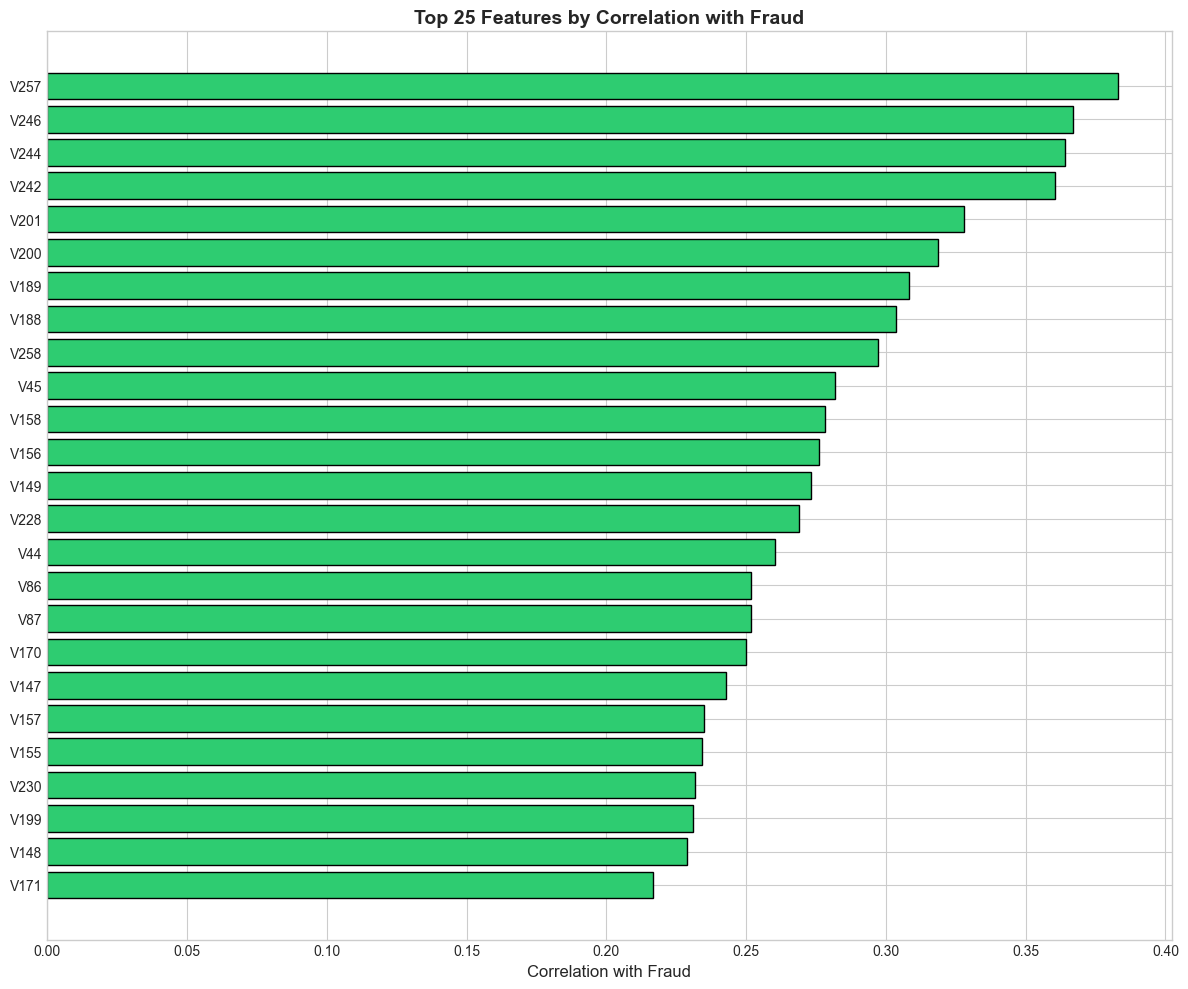

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\08_feature_correlations.png


In [23]:
# Visualization 8: Top Feature Correlations with Fraud
fig, ax = plt.subplots(figsize=(12, 10))

top_corr = corr_df.head(25)
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_corr['correlation']]
ax.barh(top_corr['feature'], top_corr['correlation'], color=colors, edgecolor='black')
ax.set_xlabel('Correlation with Fraud', fontsize=12)
ax.set_title('Top 25 Features by Correlation with Fraud', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '08_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '08_feature_correlations.png'}")

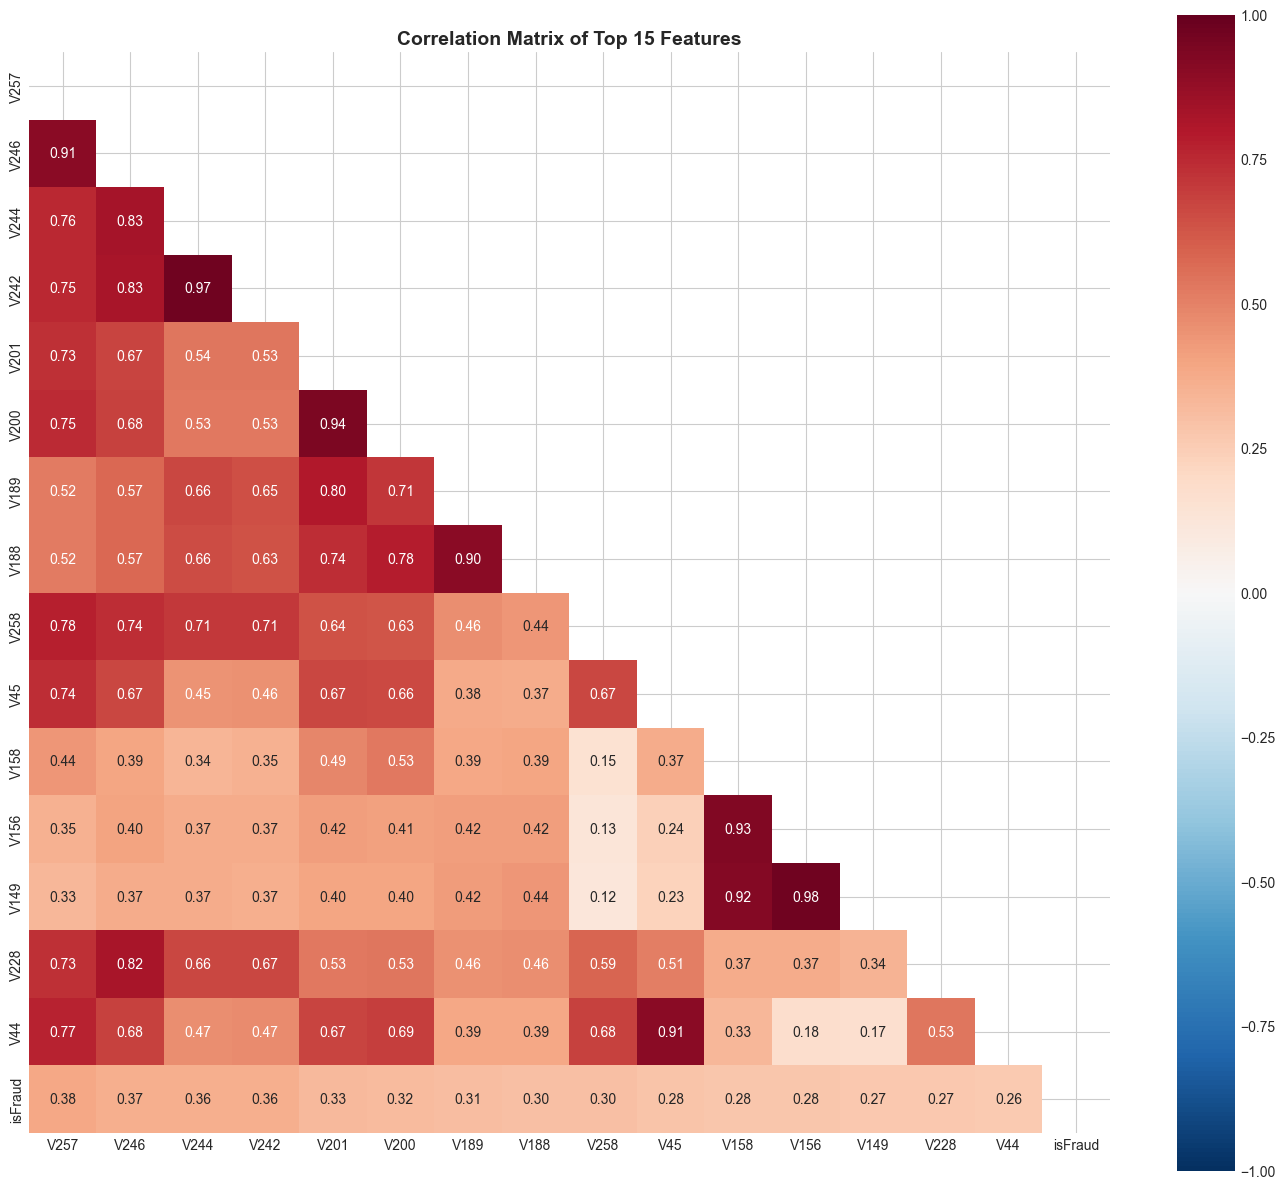

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\09_correlation_matrix.png


In [24]:
# Visualization 9: Correlation Matrix of Top Features
top_features = corr_df.head(15)['feature'].tolist() + ['isFraud']

fig, ax = plt.subplots(figsize=(14, 12))
corr_matrix = train_df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix of Top 15 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '09_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '09_correlation_matrix.png'}")

## 9. Identity Features Analysis

Identity features provide device and browser information.
These are particularly valuable for fraud detection as fraudsters often:
- Use multiple devices
- Have unusual browser configurations
- Show different patterns than legitimate users

In [25]:
# Identity feature analysis
print("=" * 60)
print("IDENTITY FEATURES ANALYSIS")
print("=" * 60)

# Check fraud rate for transactions with vs without identity info
has_identity = train_df['id_01'].notna()
fraud_with_identity = train_df[has_identity]['isFraud'].mean() * 100
fraud_without_identity = train_df[~has_identity]['isFraud'].mean() * 100

print(f"\nFraud rate WITH identity info: {fraud_with_identity:.2f}%")
print(f"Fraud rate WITHOUT identity info: {fraud_without_identity:.2f}%")
print("\nHaving identity information available is itself predictive of fraud!")

IDENTITY FEATURES ANALYSIS



Fraud rate WITH identity info: 7.85%
Fraud rate WITHOUT identity info: 2.09%

Having identity information available is itself predictive of fraud!


In [26]:
# Device Type Analysis
if 'DeviceType' in train_df.columns:
    device_fraud = train_df.groupby('DeviceType')['isFraud'].agg(['count', 'sum', 'mean'])
    device_fraud.columns = ['Count', 'FraudCount', 'FraudRate']
    device_fraud['FraudRate'] = device_fraud['FraudRate'] * 100
    print("\nFraud Rate by Device Type:")
    print(device_fraud)


Fraud Rate by Device Type:
            Count  FraudCount  FraudRate
DeviceType                              
desktop     85165        5554   6.521458
mobile      55645        5657  10.166232


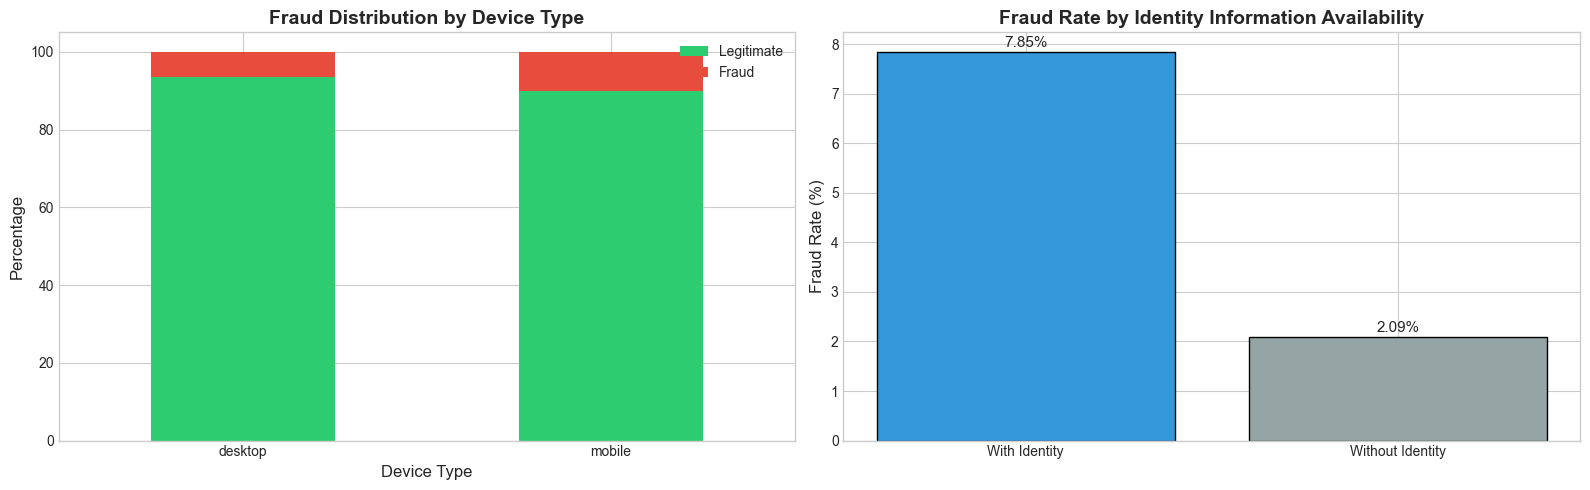

Saved: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals\10_identity_analysis.png


In [27]:
# Visualization 10: Device and Browser Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Device Type
if 'DeviceType' in train_df.columns:
    device_counts = train_df.groupby(['DeviceType', 'isFraud']).size().unstack(fill_value=0)
    device_pct = device_counts.div(device_counts.sum(axis=1), axis=0) * 100
    device_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_xlabel('Device Type', fontsize=12)
    axes[0].set_ylabel('Percentage', fontsize=12)
    axes[0].set_title('Fraud Distribution by Device Type', fontsize=14, fontweight='bold')
    axes[0].legend(['Legitimate', 'Fraud'], loc='upper right')
    axes[0].tick_params(axis='x', rotation=0)

# Identity presence impact
identity_impact = pd.DataFrame({
    'Category': ['With Identity', 'Without Identity'],
    'FraudRate': [fraud_with_identity, fraud_without_identity]
})
bars = axes[1].bar(identity_impact['Category'], identity_impact['FraudRate'], 
                   color=['#3498db', '#95a5a6'], edgecolor='black')
axes[1].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[1].set_title('Fraud Rate by Identity Information Availability', fontsize=14, fontweight='bold')
for bar, val in zip(bars, identity_impact['FraudRate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{val:.2f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / '10_identity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_PATH / '10_identity_analysis.png'}")

## 10. Key Findings Summary

### Data Characteristics
1. **Severe Class Imbalance**: ~3.5% fraud rate requires specialized handling
2. **High Dimensionality**: 400+ features, many with high missing rates
3. **Mixed Feature Types**: Numerical (V-features), categorical (cards, emails), temporal

### Feature Engineering Opportunities
1. **Temporal Features**: Hour, day, day-of-week patterns show fraud variation
2. **Identity Presence**: Missing identity data correlates with lower fraud
3. **Aggregations**: Transaction counts by card, email domain
4. **Interaction Features**: Card + address combinations

### Modeling Considerations
1. **Time-based Split**: Fraud patterns change over time (concept drift)
2. **Class Imbalance**: Use SMOTE, class weights, or PR-AUC metric
3. **Feature Selection**: Many V-features highly correlated
4. **Missing Values**: Strategic imputation needed

In [28]:
# Save EDA summary statistics
summary_stats = {
    'total_transactions': len(train_df),
    'fraud_count': train_df['isFraud'].sum(),
    'fraud_rate': train_df['isFraud'].mean(),
    'total_features': train_df.shape[1],
    'numerical_features': len(feature_types['numerical']),
    'categorical_features': len(feature_types['categorical']),
    'features_with_missing': (train_df.isnull().sum() > 0).sum(),
    'avg_transaction_amount': train_df['TransactionAmt'].mean(),
    'median_transaction_amount': train_df['TransactionAmt'].median()
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(BASE_PATH / 'outputs' / 'metrics' / 'eda_summary.csv', index=False)

# Save feature types for later use
import json
with open(BASE_PATH / 'outputs' / 'metrics' / 'feature_types.json', 'w') as f:
    json.dump(feature_types, f, indent=2)

print("EDA Summary saved to outputs/metrics/eda_summary.csv")
print("Feature types saved to outputs/metrics/feature_types.json")

EDA Summary saved to outputs/metrics/eda_summary.csv
Feature types saved to outputs/metrics/feature_types.json


In [29]:
# Clean up temporary columns
temp_cols = ['TransactionDay', 'TransactionHour', 'TransactionDayOfWeek']
train_df.drop(columns=temp_cols, inplace=True)

print("=" * 60)
print("EDA COMPLETE")
print("=" * 60)
print(f"\nVisualization files saved to: {OUTPUT_PATH}")
print("\nNext steps: Proceed to 02_feature_engineering.ipynb")

EDA COMPLETE

Visualization files saved to: C:\Users\Lenovo\Desktop\fraud-detection-mlops\outputs\visuals

Next steps: Proceed to 02_feature_engineering.ipynb
